![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
#bikes.groupby('season').total.mean()
bikes.groupby('season').total.describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


### Inferencias sobre los datos para la variable "Season"
Para la variable "Season", se tiene en la clase "1" 2686 registros, siendo éste el menor valor comparado con las otras tres clases, las cuales prácticamente tienen el mismo valor.

Con respecto al valor promedio para la variable "Total" en la clase "1" de la variable "Season" su valor es de 116.34, siendo el menor respecto a las demás clases. La clase "3" tiene un valor promedio de 234.41, el mayor, seguido por la clase "2" don un promedio de 215.25 y la clase "4" con un valor de "198".

Respecto a la desviación estándar, nuevamente la clase "1" de la variable "Season" presenta una variabilidad sensiblemente menor a las restantes clases, teniendo valores para esta estadística muy cercanos en las clases "3" y "2".

Todas las clases de la variable "Season" tienen un valor mínimo igual a 1, sin embargo en los valores máximos se aprecia nuevamente que la clase "1" tiene el menor valor de todas y la clase 3 el mayor valor.

Sobre los percentiles, se aprecia que la clase "1" de la variable "Season" en su primer cuartil (percentil 25%) presenta un valor de 24 para la variable "Total", muy por debajo de las demás clases.  Esta misma tendencia se aprecia para los percentiles 50% y 75%. la clase "3" presenta los mayores valores en cada percentil, mientras las clases "2" y "4" tienen valores cercanos en sus percentiles.

Todo lo anterior sugiere que las condiciones climáticas son menos favorables en la clase "1" (invierno) de la variable "Season" para el uso de la bicicleta y que por el contrario la clase "3" presenta condiciones que favorecen el uso de este medio de transporte (verano).

In [5]:
# Celda 1.2
#bikes.groupby('hour').total.mean()
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


### Inferencias sobre los datos para la variable "Hours"
Para la variable "Hours", se tiene en el valor "3" 433 registros, siendo éste el menor valor comparado con las demás valoes en esta variable, las cuales prácticamente tienen el mismo número. Desde esta perspectiva, a partir de la clase "2" a la clase "5" se aprecia un descenso de registros frente al resto de horas del día, siendo la clase "3" el pico de menor número de registros.

Con respecto al valor promedio para la variable "Total" analizado por las horas del día, se tienen valores por encima de 100 en la franja desde las 7 horas hasta las 22, con picos fuertes en los valores de "Hours" de 8 y en la franja de "16" a "19". Los valores  mínimos de "Total" respecto a la varaible "Hours" se extienden desde "23" hasta el valor "6", teniendo el promedio mínimo en "4".

Respecto a la variación estándar, se aprecia un comportamiento de la variabilidad de "Total" muy similar al observado en el promedio respecto a los valores de la variable "Hours", con los valores altos y bajos en las mismas franjas horarias.

Comparando los valores mínimos y máximos de "Total" respecto a "Hours" nuevamente se aprecia el mismo comportamiento de las anteriores estadísticas, franjas horarias con los mayores valores de mínimos y máximos, entre las 7 y las 22 y una franja horaria "valle" entre las 23 y las 6.

Respecto a los percentiles, se sigue presentando el mismo comportamiento observado en las otras estadísticas descriptivas, con un valor mínimo para todos los cuartiles en 4 y un máximo en 17.

Todo lo anterior permite concluir que respecto a las horas del día, el servicio de préstamo de bicicletas tiene una franja de horas valle entre las 23h y las 6h y una actividad muy fuerte entre las 7h y las 22h, alcanzando sus valores de mayor uso en la tarde.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

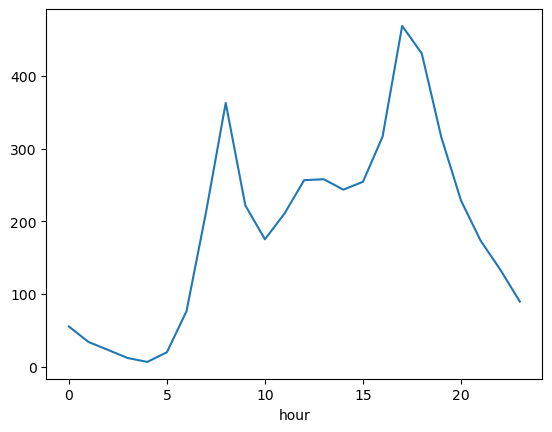

In [6]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

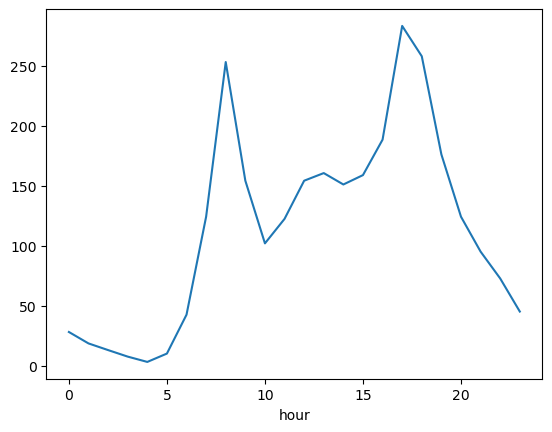

In [7]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos

bikes_inv = bikes[bikes['season'] == 1]
bikes_inv.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

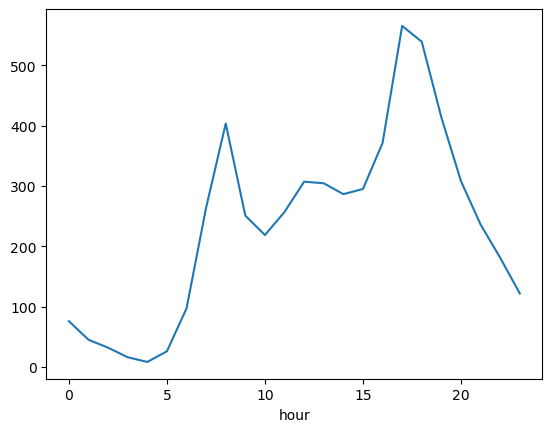

In [8]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes_ver = bikes[bikes['season'] == 3]
bikes_ver.groupby('hour').total.mean().plot()

### Hallazgos

En las 3 gráficas se aprecia el incremento del uso del servicio, con un crecimiento fuerte a partir de las 5 de la mañana con un valor máximo a las 8, un descenso a valores intermedios entre las 8 y las 15 horas y de nuevo un incremento importante en el uso del servicio con un pico a las 17 horas, para posteriormente descender nuevamente a valores mínimos sobre las 22 horas.

Comparando este comportamiento entre la estación de menor uso del servicio, el invierno (variable "Season" igual a "1"), con la estación de mayor uso de la bicicleta, el verano ("Season" igual a "3") se observa que el uso de la bicicleta en horas de la tarde es mucho mayor que en la mañana, se acentúa mucho más la diferencia entre los picos altos de uso del servicio en la franja de la tarde respecto al de la mañana en el verano, mientras que en invierno tienden a acercarse. 

Lo anterior sugiere que en verano se incrementa el uso recreativo de la bicicleta, debido a temporadas de vacaciones, mientras que en invierno el uso de la bicicleta tiene más que ver con la necesidad de transportarse para el trabajo o estudio.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [9]:
# Celda 3
# Puesto que "season" es categórica
season_dummies = pd.get_dummies(bikes['season'], prefix='season')

# Concatenar las variables dummy con el DataFrame original
bikes = pd.concat([bikes, season_dummies], axis=1)

# Definir las variables predictoras y la variable de respuesta
X = bikes[['hour', 'season_1', 'season_2', 'season_3', 'season_4']]
y = bikes['total']
Modelo_reglin= LinearRegression()
Modelo_reglin.fit(X, y)
print("Coeficientes del modelo de regresión lineal:")
print(Modelo_reglin.coef_)
y

Coeficientes del modelo de regresión lineal:
[ 10.54520609 -75.96697493  24.35025698  43.50057501   8.11614294]


datetime
2011-01-01 00:00:00     16
2011-01-01 01:00:00     40
2011-01-01 02:00:00     32
2011-01-01 03:00:00     13
2011-01-01 04:00:00      1
                      ... 
2012-12-19 19:00:00    336
2012-12-19 20:00:00    241
2012-12-19 21:00:00    168
2012-12-19 22:00:00    129
2012-12-19 23:00:00     88
Name: total, Length: 10886, dtype: int64

### Interpretación punto 3

Los coeficientes del modelo de regresión lineal muestran la variación en la respuesta debido al incremento en cada variable, a saber, por cada unidad que aumente la variable "hour" se tiene un incremento de 10.545 en el alquiler de bicicletas. De igual forma, durante el invierno ("season" igual a 1) se observa una disminución de 75.96 en la variable "total".  En el caso en que "season" sea igual a 2, se obtendrá un incremento de 24.35 en el alquiler de bicicletas. Para "season" igual a 3, este aumento en "total" será de 43.5 y finalmente, para "season" igual a 4, el aumento en "total" será de 8.116.

Las limitaciones de la regresión lineal en este caso es que el modelo está sesgado debido a su incapacidad de adaptarse a las variabilidad de la respuesta en función de las variables de entrada.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [22]:
# Celda 4
def MSE(y):
    Dif_cuad = ((y-y.mean())**2)
    MSE = Dif_cuad.sum()/Dif_cuad.shape
    return MSE[0]

# Definición de la función MSE_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
# Se usa el MSE porque se trata de un árbol de regresión
def MSE_impurity(X_col, y, split):
    
    if split == 0:
        split=1
    filter_l = X_col < split
    y_l = y[filter_l]
    y_r = y[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    MSE_y = MSE(y)
    MSE_l = MSE(y_l)
    MSE_r = MSE(y_r)
    
    MSE_impurity_ = MSE_y - (n_l / (n_l + n_r) * MSE_l + n_r / (n_l + n_r) * MSE_r)
    
    return MSE_impurity_

splits = np.percentile(X.iloc[:, 0], np.arange(0, 100, 100.0 / 10).tolist())
splits = np.unique(splits)


# Definición de la función best_split para calcular cuál es la mejor variable y 
# punto de cortepara hacer la bifurcación del árbol

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = MSE_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

j, split, gain = best_split(X, y, 5)
j, split, gain

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [37]:
tree_grow(bikes[['hour', 'season']], y, level=0, min_gain=0.001, max_depth=4, num_pct=10)

{'y_pred': 1,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'gain': 9134.40591176651,
 'sl': {'y_pred': 1,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': [0, 7.0],
  'n_samples': 3594,
  'gain': 3603.8503299798276,
  'sl': {'y_pred': 1,
   'y_prob': 32.561604584527224,
   'level': 2,
   'split': [0, 6.0],
   'n_samples': 3139,
   'gain': 323.4004463794779,
   'sl': {'y_pred': 1,
    'y_prob': 25.15934475055845,
    'level': 3,
    'split': [0, 2.0],
    'n_samples': 2684,
    'gain': 191.40441543023144,
    'sl': {'y_pred': 1,
     'y_prob': 44.41383095499451,
     'level': 4,
     'split': -1,
     'n_samples': 909,
     'gain': 145.70023409125633},
    'sr': {'y_pred': 1,
     'y_prob': 15.260551491277434,
     'level': 4,
     'split': -1,
     'n_samples': 1775,
     'gain': 19.614949636834638}},
   'sr': {'y_pred': 1,
    'y_prob': 75.92778993435448,
    'level': 3,
    'split': [1, 2.0],
    'n_samples': 455,
    'gain': 371.547796

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

Text(0, 0.5, 'Accuracy')

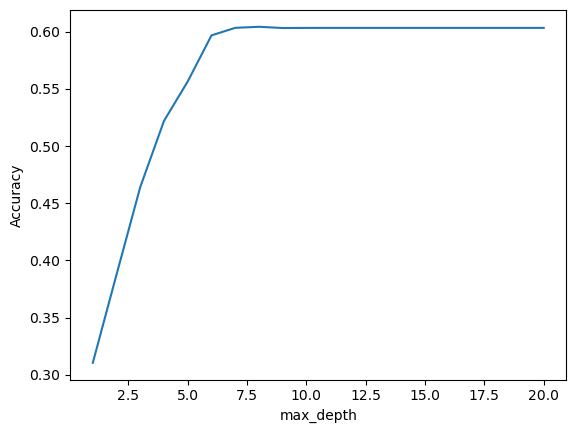

In [56]:
# Celda 5
from sklearn.model_selection import train_test_split
X_punto5 = bikes[['hour', 'season']]
X_punto5
X_train, X_test, y_train, y_test = train_test_split(X_punto5, y, test_size=0.2, random_state=0)

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad

for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeRegressor de la libreria sklearn
    Mod_treeReg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(Mod_treeReg, X_train, y_train, cv=10).mean())

# Gráfica max_depth versus RMSE (error del modelo)
import matplotlib.pyplot as plt
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [57]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.6041264398289725, 8)

In [59]:
# max_depth=8 fue el mejor, se ajusta un árbol usando este valor 
Mod_treeReg = DecisionTreeRegressor(max_depth=8, random_state=1)
Mod_treeReg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, random_state=1)

In [71]:
from sklearn.metrics import mean_squared_error

# Puesto que "season" es categórica
X_test_dummies = pd.get_dummies(X_test['season'], prefix='season')

# Concatenar las variables dummy con el DataFrame original
X_test_temp = pd.concat([X_test, X_test_dummies], axis=1)

# Definir las variables predictoras y la variable de respuesta
X_test_mrl = X_test_temp[['hour', 'season_1', 'season_2', 'season_3', 'season_4']]

y_pred_mrl= Modelo_reglin.predict(X_test_mrl)
y_pred_mtr= Mod_treeReg.predict(X_test)

# Calcular el MSE
mse_mrl = mean_squared_error(y_test, y_pred_mrl)
rmse_mrl = np.sqrt(mse_mrl)
mse_mtr = mean_squared_error(y_test, y_pred_mtr)
rmse_mtr = np.sqrt(mse_mtr)

print("El RMSE del modelo de Regresión lineal es:", rmse_mrl)
print("El RMSE del modelo de Árbol de regresión es:", rmse_mtr)

El RMSE del modelo de Regresión lineal es: 160.97943523082859
El RMSE del modelo de Árbol de regresión es: 115.52822756200692


### Desempeño del modelo de regresión y comparación con el modelo del punto 3

El modelo de Árbol de regresión logró un RMSE de 115.  Considerando las estadísticas descriptivas obtenidas en el punto 2, se aprecia que este valor es comparable en orden de magnitud a la mayoría de valores de promedios y desviaciones estándar encontrados, por lo tanto se considera necesario mejorar la precisión del modelo incluyendo más variables predictoras que permitan lograr un mejor ajuste.

Comparando su desempeño con el logrado por el modelo de regresión lineal, se aprecia que logró un mejor resultado en el RMSE.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [72]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [77]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [74]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [78]:
# Celda 6
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [79]:
#Modelo de árbol de decisión para clasificación con la calibración del parámetro max_depth

max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []
# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.6308888888888888, 2)

Text(0, 0.5, 'Accuracy')

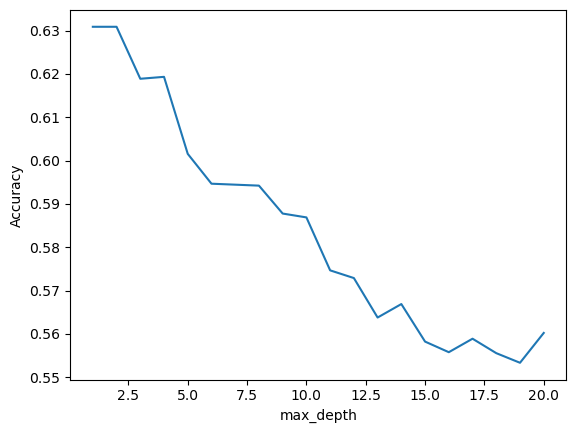

In [80]:
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [81]:
# max_depth=2 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=2, random_state=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=1)

In [82]:
# Modelo de regresión logística
mod_RegLog = LogisticRegression()

# Entrenar el modelo
mod_RegLog.fit(X_train, y_train)

LogisticRegression()

In [88]:
#Predicción con ambos modelos y evaluación de desempeño
y_pred_mtc = clf.predict(X_test)
y_pred_mrl = mod_RegLog.predict(X_test)
print("Desempeño del Modelo de clasificación por árbol de decisión:")
print("F1-Score: ", metrics.f1_score(y_pred_mtc, y_test))
print("Accuracy: ", metrics.accuracy_score(y_pred_mtc, y_test))
print("Desempeño del Modelo de Regresión logística:")
print("F1-Score: ", metrics.f1_score(y_pred_mrl, y_test))
print("Accuracy: ", metrics.accuracy_score(y_pred_mrl, y_test))

Desempeño del Modelo de clasificación por árbol de decisión:
F1-Score:  0.6448598130841121
Accuracy:  0.6453333333333333
Desempeño del Modelo de Regresión logística:
F1-Score:  0.6110363391655451
Accuracy:  0.6146666666666667


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [105]:
# Celda 7
# Creación de 300 muestras de bootstrap
n_estimators = 300
muestra_modelo = 100
np.random.seed(123)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

sample_1 = samples[:100]
sample_2 = samples[100:200]
sample_3 = samples[200:300]

#Crear los 3 modelos de clasificación
Modelo_tc_max_depth = DecisionTreeClassifier(max_depth=5)
Modelo_tc_min_samples_leaf = DecisionTreeClassifier(min_samples_leaf=10)
Mod_reg_log = LogisticRegression()

#Entrenar cada modelo
trees_max_depth = {}
for i in range(muestra_modelo):
    trees_max_depth[i] = Modelo_tc_max_depth.fit(X_train.iloc[sample_1[i]], y_train.iloc[sample_1[i]])

trees_min_samples_leaf = {}
for i in range(muestra_modelo):
    trees_min_samples_leaf[i] = Modelo_tc_min_samples_leaf.fit(X_train.iloc[sample_2[i]], y_train.iloc[sample_2[i]])

regres_log = {}
for i in range(muestra_modelo):
    regres_log[i] = Mod_reg_log.fit(X_train.iloc[sample_3[i]], y_train.iloc[sample_3[i]])

In [115]:
# Predicción para los datos del set de test con cada modelo
y_pred_df_trees_max_dept = pd.DataFrame(index=X_test.index, columns=list(range(muestra_modelo)))
for i in range(muestra_modelo):
    y_pred_df_trees_max_dept.iloc[:, i] = trees_max_depth[i].predict(X_test)

y_pred_df_trees_min_samples = pd.DataFrame(index=X_test.index, columns=list(range(muestra_modelo)))
for i in range(muestra_modelo):
    y_pred_df_trees_min_samples.iloc[:, i] = trees_min_samples_leaf[i].predict(X_test)

y_pred_df_regres_log = pd.DataFrame(index=X_test.index, columns=list(range(muestra_modelo)))
for i in range(muestra_modelo):
    y_pred_df_regres_log.iloc[:, i] = regres_log[i].predict(X_test)

y_pred_df = pd.concat([y_pred_df_trees_max_dept, y_pred_df_trees_min_samples, y_pred_df_regres_log], axis=1)

# Votación mayoritaria
y_pred_trees_max_dept=(y_pred_df_trees_max_dept.sum(axis=1) >= (n_estimators / 2)).astype(np.int)
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)
print("f1-score para modelo bagged de 300 modelos y votación mayoritaria: ", metrics.f1_score(y_pred, y_test))
#metrics.f1_score(y_pred, y_test)

f1-score para modelo bagged de 300 modelos y votación mayoritaria:  0.6505102040816327


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [ ]:
# Celda 8


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [ ]:
# Celda 9